In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp "/content/drive/My Drive/Data/glove.twitter.27B.100d.txt" "glove27B"
# # Can't run this because of google collab ram limitation
# #!cp "/content/drive/My Drive/Data/glove.twitter.27B.200d.txt" "glove_twitter27B"
# # Can't run this because of google collab ram limitation
# #!cp "/content/drive/My Drive/Data/GoogleNews-vectors-negative300.bin" "word2vec"

In [3]:
#Loading the libraries
import tensorflow as tf

import numpy as np
import pandas as pd
from  IPython import display
from matplotlib import pyplot as plot

from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import pathlib
import shutil
import tempfile
from sklearn.metrics import classification_report

from  IPython import display
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
import re

#important libraries for preprocessing using NLTK
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from collections import Counter
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix

!pip install tweet-preprocessor
import preprocessor as p


!python -m pip install -U gensim
from gensim.parsing.preprocessing import remove_stopwords

!pip install ekphrasis

# Segmenter used for sengmenting the hashtags
from ekphrasis.classes.segmenter import Segmenter
#segmenter using the word statistics from Twitter
seg = Segmenter(corpus="twitter")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)
Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [4]:
#To Preprocess using the functions from tweet-processor package
def preprocess_tweet(row):
    text = row['Tweet']
    text = p.clean(text)
    return text

In [5]:
#Using WordNet Lemmatizer
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()
word_tokenizer = TweetTokenizer()
#Lemmatize_text function lemmatizes the words
def lemmatize_text(text):
     return [(lemmatizer.lemmatize(w)) for w in \
                                     word_tokenizer.tokenize((text))]

In [6]:
#Convert list to string function
def convert_list_to_string(original_list, separator=' '):
    return separator.join(original_list)

In [7]:
def loadGloveVector():
  glove_vectors = dict()
  file = open('glove27B', encoding='utf-8')
  for line in file:
    values = line.split()
    word = values[0]
    features = np.asarray(values[1:])
    glove_vectors[word] = features

  file.close()
  return glove_vectors


In [8]:
def generateEmbeddingVector():
  #Loading the glove vector
  glove_vectors = loadGloveVector()


  #Creating the embedding vector
  E_T = np.zeros((len(word_index) + 1, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = glove_vectors.get(word)
      if embedding_vector is not None:
          E_T[i] = embedding_vector
  return E_T

In [9]:
!ls


drive  glove27B  sample_data


In [10]:
#Loading the file
pd.set_option('max_colwidth',150)
filename = "/content/drive/My Drive/Data/train.csv"
tweets_df = pd.read_csv(filename,index_col=None, header=0, engine='python')

In [11]:
#Checking the contents of the datafile

tweets_df.head(10)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,Hillary Clinton,FAVOR,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
4,@PortiaABoulger Thank you for adding me to your list,Hillary Clinton,NONE,"3. The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)",pos
5,Hillary can not win. Here's hoping the Dems offer a real candidate like Warren. #Warren2016,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
6,"Respect FOR the law and respect BY the law Yes, needed desperately. #BaltimoreRiots",Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,pos
7,I don't want to be appointed to an Ambassador post.,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg
8,"#StopHillary2016 @HillaryClinton if there was a woman with integrity and honesty I would vote for such as woman president, NO",Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
9,@HillaryClinton End lawless #ClintonFoundation. Jail Butcher of #Benghazi. #Arrest rapist #BillClinton. #HillaryClinton,Hillary Clinton,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg


In [12]:
tweets_df = tweets_df[['Tweet','Target','Stance']]

In [13]:
#Checking the tweet text content
print(tweets_df['Tweet'][0])

@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot


In [14]:
#Checking the values in Target Column
tweets_df['Target'].value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

In [15]:
#Checking the values in Stance Column
tweets_df['Stance'].value_counts()

AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64

In [16]:
#Checking the values grouped by Target and Stance
tweets_df.groupby(['Target','Stance']).size()

Target                            Stance 
Atheism                           AGAINST    304
                                  FAVOR       92
                                  NONE       117
Climate Change is a Real Concern  AGAINST     15
                                  FAVOR      212
                                  NONE       168
Feminist Movement                 AGAINST    328
                                  FAVOR      210
                                  NONE       126
Hillary Clinton                   AGAINST    393
                                  FAVOR      118
                                  NONE       178
Legalization of Abortion          AGAINST    355
                                  FAVOR      121
                                  NONE       177
dtype: int64

In [17]:
tweets_df['wordCount'] = tweets_df['Tweet'].apply(lambda x: len(str(x).split()))

In [18]:
tweets_df.head()

,Tweet,Target,Stance,wordCount
0,"@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot",Hillary Clinton,AGAINST,17
1,Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio,Hillary Clinton,FAVOR,16
2,"@TheView I think our country is ready for a female pres, it can't ever be Hillary",Hillary Clinton,AGAINST,16
3,I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary,Hillary Clinton,AGAINST,19
4,@PortiaABoulger Thank you for adding me to your list,Hillary Clinton,NONE,9


In [19]:
tweets_df['wordCount'].describe()

count    2914.000000
mean       17.241592
std         4.680375
min         6.000000
25%        14.000000
50%        18.000000
75%        21.000000
max        32.000000
Name: wordCount, dtype: float64

In [20]:
#Hastag and Mentions Preprocessing

tweets_df["mention"] = tweets_df["Tweet"].apply(lambda x: re.findall(r"@(\w+)", x))
tweets_df["hashtag"] = tweets_df["Tweet"].apply(lambda x: re.findall(r"#(\w+)", x))
tweets_df['hashtag_string'] = tweets_df['hashtag'].apply(convert_list_to_string)

#Segmenting the hashtags
for i in range(tweets_df.shape[0]):
    tweets_df["hashtag_string"][i] = seg.segment(tweets_df["hashtag_string"][i])
    
#Appending Hashtags to the Tweet Text
for i in range(tweets_df.shape[0]):
    tweets_df["Tweet"][i] = tweets_df["Tweet"][i] + " " + tweets_df["hashtag_string"][i]

#Appending target to the Tweet Text
for i in range(tweets_df.shape[0]):
    tweets_df["Tweet"][i] = tweets_df["Target"][i] + " " + tweets_df["Tweet"][i]

tweets_df.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Tweet,Target,Stance,wordCount,mention,hashtag,hashtag_string
0,"Hillary Clinton @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot ha...",Hillary Clinton,AGAINST,17,[tedcruz],"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot
1,Hillary Clinton Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio ohio,Hillary Clinton,FAVOR,16,[],[Ohio],ohio
2,"Hillary Clinton @TheView I think our country is ready for a female pres, it can't ever be Hillary",Hillary Clinton,AGAINST,16,[TheView],[],
3,Hillary Clinton I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary why i...,Hillary Clinton,AGAINST,19,[],[WhyImNotVotingForHillary],why im not voting for hillary
4,Hillary Clinton @PortiaABoulger Thank you for adding me to your list,Hillary Clinton,NONE,9,[PortiaABoulger],[],


In [21]:
#Clean the mentions and hashtags,urls and mentions from the tweet text using preprocess function 
#from tweet-preprocessor
tweets_df['Tweet'] = tweets_df.apply(preprocess_tweet, axis = 1)

#Convert the text to lower text and remove punctuations
tweets_df['Tweet'] = tweets_df['Tweet'].str.lower().str.replace('[^\w\s]','').str.replace('\s\s+', '')

#Remove Digits from the Tweet
tweets_df['Tweet'] = tweets_df['Tweet'].str.replace('\d+', '')

#Lemmatize and tokenize text
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lemmatize_text)

# tweets_df["Tweet"] = tweets_df["Tweet"].apply(lambda x: [word.replace('semst','') for word in x])
# tweets_df["Tweet"] = tweets_df["Tweet"].apply(lambda x: [word.replace('sem st','') for word in x])
# tweets_df["Tweet"] = tweets_df["Tweet"].apply(lambda x: [word.replace('sem','') for word in x])
# tweets_df["Tweet"] = tweets_df["Tweet"].apply(lambda x: [word.replace('st','') for word in x])


#Last step is to remove the stop words from the lemmatized and tokenized words lists
stop_words = set(stopwords.words('english'))
tweets_df['Tweet'] = tweets_df['Tweet'].apply(lambda x: [item for item in \
                                                         x if item not in stop_words])

tweets_df.head(5)

,Tweet,Target,Stance,wordCount,mention,hashtag,hashtag_string
0,"[hillary, clinton, wiped, cleank, deleted, email, explains, dereliction, dutylies, etc, hand, server, benghazi, tcot]",Hillary Clinton,AGAINST,17,[tedcruz],"[HandOverTheServer, Benghazi, tcot]",hand over the server benghazi tcot
1,"[hillary, clinton, hillary, best, choice, truly, want, continue, progressive, nation, ohio]",Hillary Clinton,FAVOR,16,[],[Ohio],ohio
2,"[hillary, clinton, think, country, ready, female, pres, cant, ever, hillary]",Hillary Clinton,AGAINST,16,[TheView],[],
3,"[hillary, clinton, gave, unhealthy, amount, hardearned, money, away, big, govtuntrustworthy, irs, im, voting, hillary]",Hillary Clinton,AGAINST,19,[],[WhyImNotVotingForHillary],why im not voting for hillary
4,"[hillary, clinton, thank, adding, list]",Hillary Clinton,NONE,9,[PortiaABoulger],[],


In [22]:
tweets_df['Target'].unique()

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement'],
      dtype=object)

In [23]:
!pip install wordcloud


 Generating Word Cloud for Hillary Clinton 



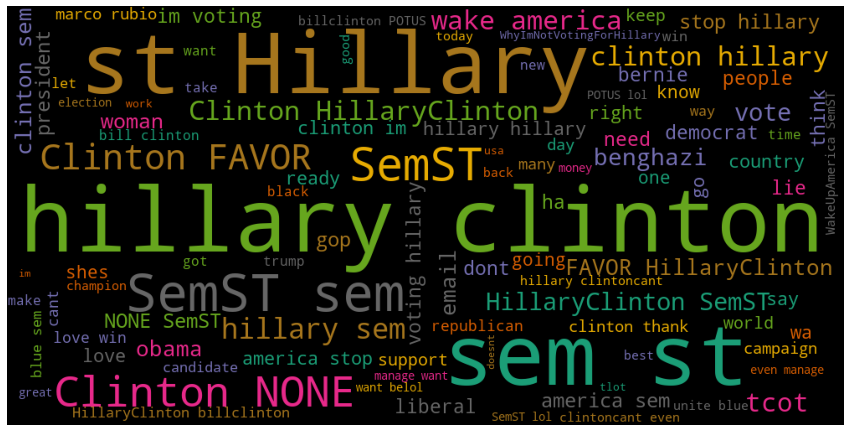


 Generating Word Cloud for Legalization of Abortion 



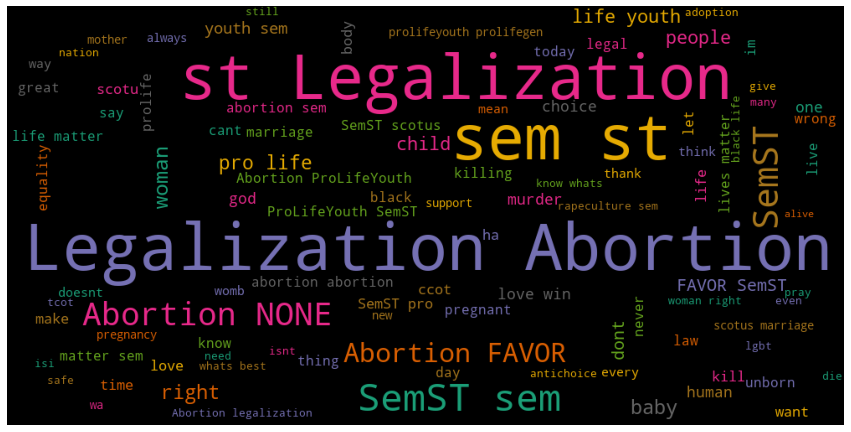


 Generating Word Cloud for Atheism 



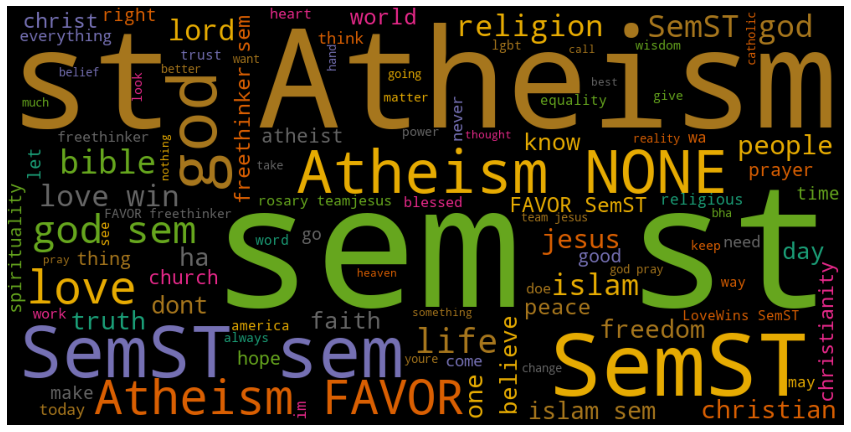


 Generating Word Cloud for Climate Change is a Real Concern 



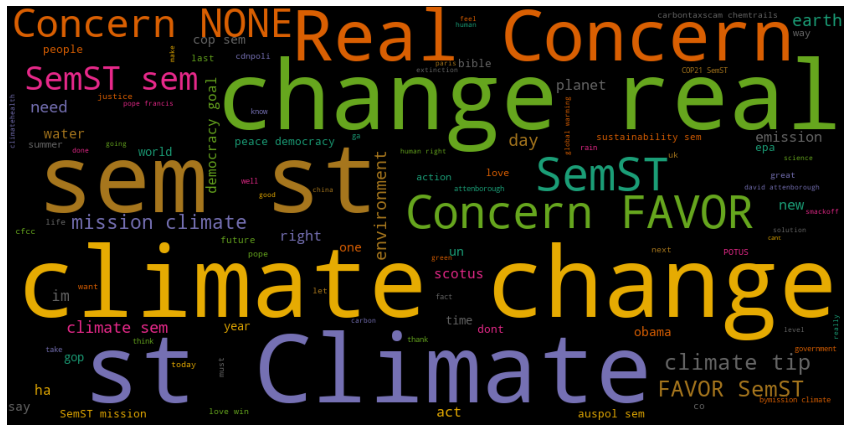


 Generating Word Cloud for Feminist Movement 



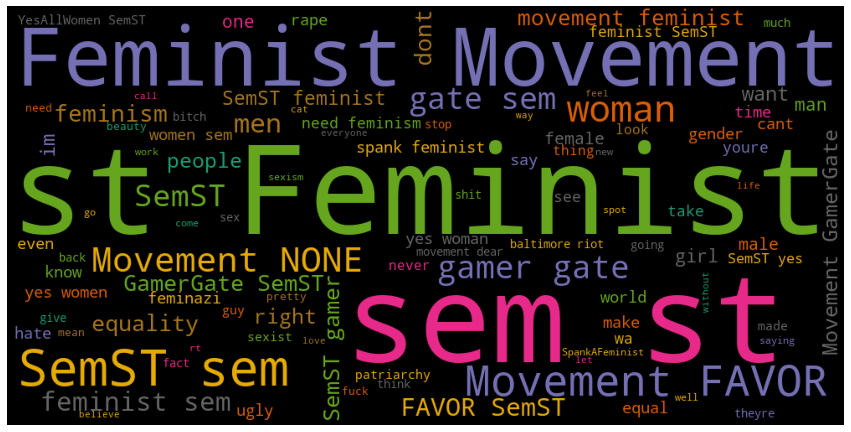

In [24]:
#For loop for generating word cloud for each target variable
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

target_list = ['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement']



for target in target_list:
    wordcloud = WordCloud(width = 1000, height = 500,max_words=100, colormap="Dark2")
    print("\n Generating Word Cloud for {} \n".format(target))
    wordcloud.generate(tweets_df[tweets_df.iloc[:,1] == target].to_string())
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

In [25]:
tweets_df.shape

(2914, 7)

In [26]:
#Converting the strings to tweets
tweets_df['Tweet'] = tweets_df['Tweet'].apply(convert_list_to_string)

In [27]:
tweets_df['Tweet'].head()

0     hillary clinton wiped cleank deleted email explains dereliction dutylies etc hand server benghazi tcot
1                            hillary clinton hillary best choice truly want continue progressive nation ohio
2                                          hillary clinton think country ready female pres cant ever hillary
3    hillary clinton gave unhealthy amount hardearned money away big govtuntrustworthy irs im voting hillary
4                                                                          hillary clinton thank adding list
Name: Tweet, dtype: object

In [28]:
#Coverting stances to one-hot-encoding for model input
labels = tweets_df['Stance']
labels = pd.get_dummies(labels).values
print(labels)
labels.shape

[[1 0 0]
 [0 1 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


(2914, 3)

In [29]:
#Tokenizing the words for 
from keras.preprocessing.text import Tokenizer
# SOME MACROS That we need to tune later
MAX_SEQ_LENGTH = 50
MAX_WORDS = 20000

all_text = tweets_df['Tweet'].tolist()

#Truncating the words based on the maximum number of words allowed
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(all_text)
#Integer Encoding 
sequences = tokenizer.texts_to_sequences(all_text)
word_index = tokenizer.word_index

#Padding the sequences so that all the texts are of the same lengh
from keras.preprocessing.sequence import pad_sequences
input_data_tensor = pad_sequences(sequences,maxlen= MAX_SEQ_LENGTH )

vocab_dim= len(tokenizer.word_index)+1
print(vocab_dim)

7595


In [30]:
#Checking the contents of the train data
print(input_data_tensor)
#Shape of the matrix
print("Shape of Train Data:"+ str(input_data_tensor.shape))

[[   0    0    0 ...  756  182   78]
 [   0    0    0 ...  649  183 1301]
 [   0    0    0 ...   46  126    3]
 ...
 [   0    0    0 ... 1479    2    1]
 [   0    0    0 ...   15    2    1]
 [   0    0    0 ...  375    2    1]]
Shape of Train Data:(2914, 50)


In [31]:
# #Integer Encoding the stance labels
# encoded_targets = []
# for target in targets:
    
#     if target == "Hillary Clinton":
#         encoded_targets.append(0)
#     elif target == "Climate Change is a Real Concern":
#         encoded_targets.append(2)
#     elif target == "Feminist Movement":
#         encoded_targets.append(3)
#     elif target == "Legalization of Abortion":
#         encoded_targets.append(4)
#     else:
#         encoded_targets.append(5)

# target_labels = encoded_targets
# encoded_target_labels = np.array(target_labels)
# print(encoded_target_labels)

## MODELING

In [59]:
#evaluateModel function evaluates the model
def evaluateModel(model,X_val,labels):
  y_pred = model.predict_classes(X_val)
  y_true = np.argmax(labels,axis=1)

  print('Confusion Matrix')
  print(confusion_matrix(y_true, y_pred))
  print('Classification Report')
  target_names = ['AGAINST', 'FAVOR', 'NONE']
  print(classification_report(y_true, y_pred, target_names=target_names))

In [33]:
def displayPlots(history):
    ## Accuracy Graph
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    ##Loss Graph
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [34]:
from itertools import cycle
def plotter(history_hold, metric = 'CategoricalCrossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

In [42]:
def kcross_evaluation_framework(model,folds_num = 3):
  kfold = KFold(n_splits = folds_num, shuffle =True)
  input = input_data_tensor
  label = labels
  k=1

  for train,val in kfold.split(input, label):
    print("Fold Number: ", k)
    # Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 5
    monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=5,verbose=1,restore_best_weights=True)
    
    history = model.fit(input[train], label[train], batch_size=64, 
                                        epochs=50, validation_data=(input[val], label[val]), verbose=1,callbacks=[monitor])
    displayPlots(history)
    k = k+1

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(input_data_tensor, labels, test_size=0.2, random_state=42)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (2331, 50)
y_train shape:  (2331, 3)
X_val shape:  (583, 50)
y_val shape:  (583, 3)


**Model1:** Four weight layered base model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           759500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 778,831
Trainable params: 778,831
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
37/37 [==============================] - 4s 102ms/step - loss: 1.0676 - categorical_accuracy: 0.4689 - val_loss: 1.0396 - val_categorical_accuracy: 0.4837
Epoch 2/50
37/37 [==============================] - 3s 88ms/step - loss: 0.

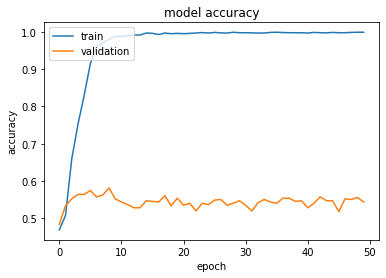

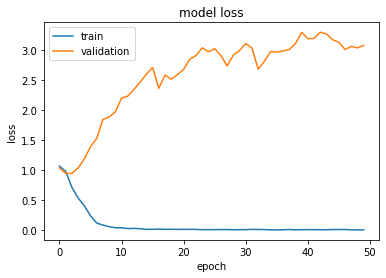

In [38]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

#Macros for model tuning
max_length = 50
embedding_dim = 100
rnn_dim = 32
FC_dim = 64
number_of_class =3
dropout_rate = 0.5
recurrent_dropout_rate = 0.25


embedding_layer = Embedding(vocab_dim,
                            embedding_dim,
                            input_length=max_length,
                            trainable=True)
model1 = Sequential()
model1.add(embedding_layer)
model1.add(LSTM(units=rnn_dim,dropout= dropout_rate, recurrent_dropout=dropout_rate))
model1.add(Dense(FC_dim, activation='relu'))
model1.add(Dense(number_of_class, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model1.summary())

history = model1.fit(X_train, y_train, batch_size=64, 
                                       epochs=50, validation_data=(X_val, y_val), verbose=1)
displayPlots(history)

**Model2:** Base model with increased regularization
- *Since model1 was overfitting we are applying dropout to prevent overfitting*

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           759500    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 778,831
Trainable params: 778,831
Non-trainable params: 0
________________________________________________

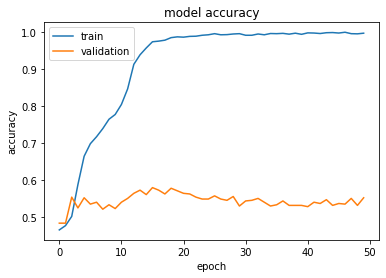

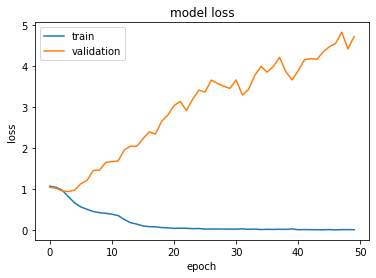

In [39]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

#Macros for model tuning
max_length = 50
embedding_dim = 100
rnn_dim = 32
FC_dim = 64
number_of_class =3
dropout_rate = 0.6
recurrent_dropout_rate = 0.25


embedding_layer = Embedding(vocab_dim,
                            embedding_dim,
                            input_length=max_length,
                            trainable=True)
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(units=rnn_dim,dropout= dropout_rate, recurrent_dropout=dropout_rate))
model2.add(Dropout(dropout_rate))
model2.add(Dense(FC_dim, activation='relu'))
model2.add(Dropout(dropout_rate))
model2.add(Dense(number_of_class, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model2.summary())

history = model2.fit(X_train, y_train, batch_size=64, 
                                       epochs=50, validation_data=(X_val, y_val), verbose=1)
displayPlots(history)

## APPLYING TRANSFER LEARNING

**model3:** Using glove 27 million twitter 100d global vector as pre-trained weights to improve performance

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           759500    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 778,831
Trainable params: 19,331
Non-trainable params: 759,500
___________________________________________

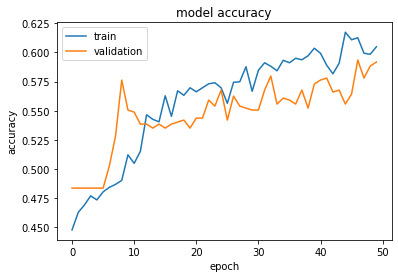

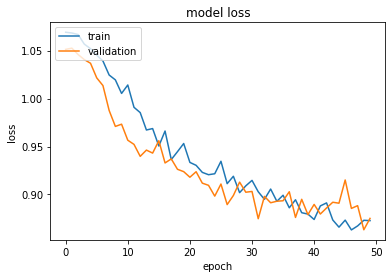

In [40]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 100
max_length = 50
number_of_class =3
rnn_dim = 32
dropout_rate = 0.6
dense_dim = 64

#Generate the embedding vector
E_T =generateEmbeddingVector()

embedding_layer = Embedding(vocab_dim,
                            embedding_dim,
                            input_length=max_length,
                            weights=[E_T],
                            trainable=False)
model3 = Sequential()
model3.add(embedding_layer)
model3.add(LSTM(units=rnn_dim,dropout= dropout_rate, recurrent_dropout=dropout_rate))
model3.add(Dropout(0.6))
model3.add(Dense(dense_dim, activation = "relu"))
model3.add(Dropout(0.4)),
model3.add(Dense(number_of_class, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model3.summary())

history = model3.fit(X_train, y_train, batch_size=64, 
                                       epochs=50, validation_data=(X_val, y_val), verbose=1)
displayPlots(history)

**model3V2:** Using K-cross Validation With 3 Folds. This is also configured with Early Stopping

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           759500    
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 778,831
Trainable params: 19,331
Non-trainable params: 759,500
___________________________________________

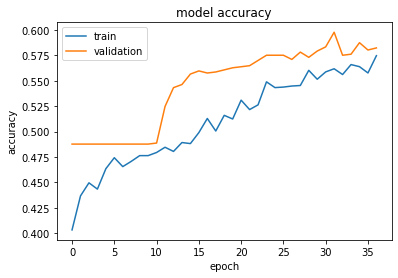

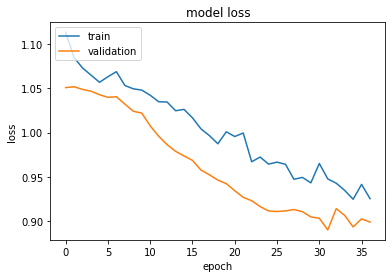

Fold Number:  2
Epoch 1/50
31/31 [==============================] - 2s 76ms/step - loss: 0.9391 - categorical_accuracy: 0.5682 - val_loss: 0.8913 - val_categorical_accuracy: 0.5654
Epoch 2/50
31/31 [==============================] - 2s 75ms/step - loss: 0.9439 - categorical_accuracy: 0.5651 - val_loss: 0.8733 - val_categorical_accuracy: 0.5808
Epoch 3/50
31/31 [==============================] - 2s 74ms/step - loss: 0.9358 - categorical_accuracy: 0.5656 - val_loss: 0.8877 - val_categorical_accuracy: 0.5767
Epoch 4/50
31/31 [==============================] - 2s 73ms/step - loss: 0.9309 - categorical_accuracy: 0.5682 - val_loss: 0.8848 - val_categorical_accuracy: 0.5778
Epoch 5/50
31/31 [==============================] - 2s 73ms/step - loss: 0.9359 - categorical_accuracy: 0.5600 - val_loss: 0.8866 - val_categorical_accuracy: 0.5819
Epoch 6/50
31/31 [==============================] - 2s 72ms/step - loss: 0.9356 - categorical_accuracy: 0.5800 - val_loss: 0.8860 - val_categorical_accuracy: 0

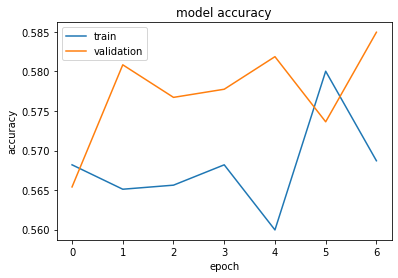

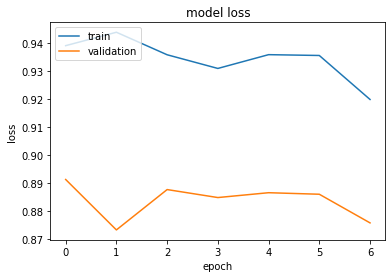

Fold Number:  3
Epoch 1/50
31/31 [==============================] - 2s 74ms/step - loss: 0.9584 - categorical_accuracy: 0.5574 - val_loss: 0.8576 - val_categorical_accuracy: 0.5881
Epoch 2/50
31/31 [==============================] - 2s 73ms/step - loss: 0.9519 - categorical_accuracy: 0.5528 - val_loss: 0.8525 - val_categorical_accuracy: 0.5953
Epoch 3/50
31/31 [==============================] - 2s 72ms/step - loss: 0.9458 - categorical_accuracy: 0.5672 - val_loss: 0.8614 - val_categorical_accuracy: 0.5881
Epoch 4/50
31/31 [==============================] - 2s 73ms/step - loss: 0.9402 - categorical_accuracy: 0.5651 - val_loss: 0.8518 - val_categorical_accuracy: 0.5922
Epoch 5/50
31/31 [==============================] - 2s 73ms/step - loss: 0.9346 - categorical_accuracy: 0.5672 - val_loss: 0.8554 - val_categorical_accuracy: 0.5953
Epoch 6/50
31/31 [==============================] - 2s 74ms/step - loss: 0.9451 - categorical_accuracy: 0.5656 - val_loss: 0.8632 - val_categorical_accuracy: 0

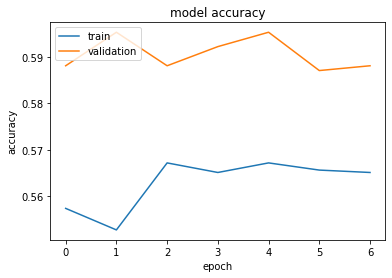

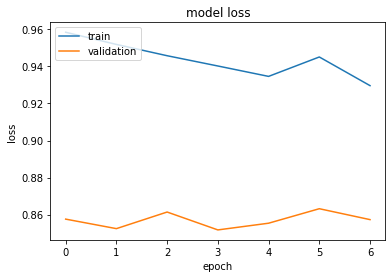

In [43]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 100
max_length = 50
number_of_class =3
rnn_dim = 32
dropout_rate = 0.6
dense_dim = 64

#Generate the embedding vector
E_T =generateEmbeddingVector()

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=max_length,
                            weights=[E_T],
                            trainable=False)
model3V2 = Sequential()
model3V2.add(embedding_layer)
model3V2.add(LSTM(units=rnn_dim,dropout= dropout_rate, recurrent_dropout=dropout_rate))
model3V2.add(Dropout(dropout_rate)),
model3V2.add(Dense(dense_dim, activation = "relu"))
model3V2.add(Dropout(dropout_rate)),
model3V2.add(Dense(number_of_class, activation='softmax'))

model3V2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model3V2.summary())

kcross_evaluation_framework(model3V2)

**model4**: Inceasing capacity of previous model by keeping two Bi-Directional LSTM and two fully connected layers with Batch Normalization

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           759500    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 64)            34048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

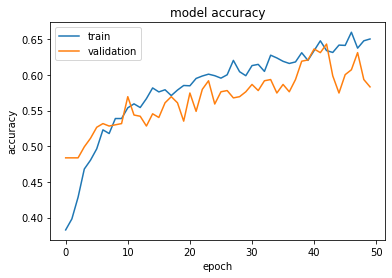

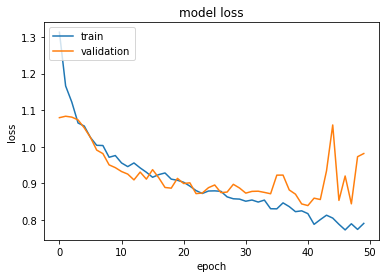

In [44]:
#Model Macros defined
#Embedding dimension
embedding_dim = 100
#Length of the data
max_length = 50
#Number of class
number_of_class =3
#Dropout Rate
dropout_rate = 0.6
#Dense Node Dimension
dense_dim = 128

#Generate the embedding vector
E_T =generateEmbeddingVector()


embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=max_length,
                            weights=[E_T],
                            trainable=False)

model4 = Sequential()
model4.add(embedding_layer)
model4.add(Bidirectional(LSTM(units=32, dropout=dropout_rate, recurrent_dropout=0.25,return_sequences=True))),
model4.add(Bidirectional(LSTM(units=64, dropout=dropout_rate, recurrent_dropout=0.25,return_sequences=False))),
model4.add(BatchNormalization())
model4.add(Dense(dense_dim,activation = "relu"))
model4.add(Dropout(dropout_rate)),
model4.add(Dense(dense_dim,activation = "relu")),
model4.add(Dropout(dropout_rate)),
model4.add(Dense(number_of_class, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model4.summary())

history = model4.fit(X_train, y_train, batch_size=64, 
                                       epochs=50, validation_data=(X_val, y_val), verbose=1)
displayPlots(history)

**model5:** Experimenting with Gated Recurrent Unit (GRU)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           759500    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 64)            25728     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               49920     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 387       
Total params: 852,047
Trainable params: 92,547
Non-trainable params: 759,500
_________________________________________________________________
None
Epoch 1/50
37/37 [==============================] - 11s 305ms/step - loss: 1.0606 - categorical_accuracy

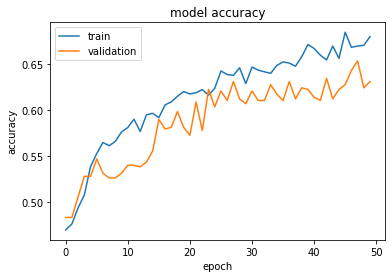

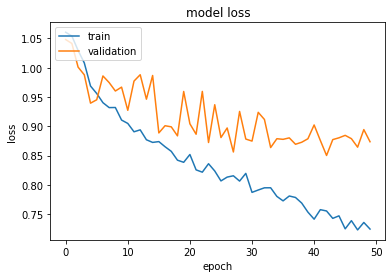

In [45]:
#Model Macros defined
#Embedding dimension
embedding_dim = 100
#Length of the data
max_length = 50
#Number of class
number_of_class =3
#Dropout Rate
dropout_rate = 0.6
#Dense Node Dimension
dense_dim = 128

#Generate the embedding vector
E_T =generateEmbeddingVector()
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=max_length,
                            weights=[E_T],
                            trainable=False)

model5 = Sequential()
model5.add(embedding_layer)
model5.add(Bidirectional(GRU(units=32, dropout=dropout_rate, recurrent_dropout=0.25,return_sequences=True)))
model5.add(Bidirectional(GRU(units=64, dropout=dropout_rate, recurrent_dropout=0.25,return_sequences=False)))
model4.add(Dropout(dropout_rate)),
model5.add(Dense(dense_dim,activation = "relu")),
model4.add(Dropout(dropout_rate)),
model5.add(Dense(number_of_class, activation='softmax'))

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model5.summary())

history = model5.fit(X_train, y_train, batch_size=64, 
                                       epochs=50, validation_data=(X_val, y_val), verbose=1)
displayPlots(history)

## TESTING MODEL PERFORMANCE

In [47]:
filename = "/content/drive/My Drive/Data/test.csv"
test_data = pd.read_csv(filename,index_col=None, header=0, engine='python')
test_data = test_data[test_data['Target'] != "Donald Trump"]
test_data.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; and he who humbles himself shall be exalted.Matt 23:12. #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
1,"RT @prayerbullets: I remove Nehushtan -previous moves of God that have become idols, from the high places -2 Kings 18:4 #SemST",Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",other
2,@Brainman365 @heidtjj @BenjaminLives I have sought the truth of my soul and found it strong enough to stand on its own merits. #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos
3,#God is utterly powerless without Human intervention... #SemST,Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",neg
4,@David_Cameron Miracles of #Multiculturalism Miracles of shady 786 #Taqiya #Tawriya #Jaziya #Kafirs #Dhimmi #Jihad #Allah #SemST,Atheism,AGAINST,2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.,neg


In [48]:
test_data.shape

(1249, 5)

In [49]:
test_data.groupby(['Target','Stance']).size()

Target                            Stance 
Atheism                           AGAINST    160
                                  FAVOR       32
                                  NONE        28
Climate Change is a Real Concern  AGAINST     11
                                  FAVOR      123
                                  NONE        35
Feminist Movement                 AGAINST    183
                                  FAVOR       58
                                  NONE        44
Hillary Clinton                   AGAINST    172
                                  FAVOR       45
                                  NONE        78
Legalization of Abortion          AGAINST    189
                                  FAVOR       46
                                  NONE        45
dtype: int64

In [50]:
#Hastag and Mentions Preprocessing

test_data["mention"] = test_data["Tweet"].apply(lambda x: re.findall(r"@(\w+)", x))
test_data["hashtag"] = test_data["Tweet"].apply(lambda x: re.findall(r"#(\w+)", x))
test_data['hashtag_string'] = test_data['hashtag'].apply(convert_list_to_string)

#Segmenting the hashtags
for i in range(test_data.shape[0]):
    test_data["hashtag_string"][i] = seg.segment(test_data["hashtag_string"][i])
    
#Appending Hashtags to the Tweet Text
for i in range(test_data.shape[0]):
    test_data["Tweet"][i] = test_data["Tweet"][i] + " " + test_data["hashtag_string"][i]

#Appending target to the Tweet Text
for i in range(test_data.shape[0]):
    test_data["Tweet"][i] = test_data["Target"][i] + " " + test_data["Tweet"][i]

#Clean the mentions and hashtags,urls and mentions from the tweet text using preprocess function 
#from tweet-preprocessor
test_data['Tweet'] = test_data.apply(preprocess_tweet, axis = 1)

#Convert the text to lower text and remove punctuations
test_data['Tweet'] = test_data['Tweet'].str.lower().str.replace('[^\w\s]','').str.replace('\s\s+', '')

#Remove Digits from the Tweet
test_data['Tweet'] = test_data['Tweet'].str.replace('\d+', '')

test_data['Tweet'] = test_data['Tweet'].apply(lemmatize_text)

# test_data["Tweet"] = test_data["Tweet"].apply(lambda x: [word.replace('semst','') for word in x])
# test_data["Tweet"] = test_data["Tweet"].apply(lambda x: [word.replace('sem st','') for word in x])
# test_data["Tweet"] = test_data["Tweet"].apply(lambda x: [word.replace('sem','') for word in x])
# test_data["Tweet"] = test_data["Tweet"].apply(lambda x: [word.replace('st','') for word in x])


#Last step is to remove the stop words from the lemmatized and tokenized words lists
stop_words = set(stopwords.words('english'))
test_data['Tweet'] = test_data['Tweet'].apply(lambda x: [item for item in \
                                                         x if item not in stop_words])

test_data.head(2)

,Tweet,Target,Stance,Opinion Towards,Sentiment,mention,hashtag,hashtag_string
0,"[atheism, exalts, shall, humbled, humbles, shall, exaltedmatt, sem, st]",Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",pos,[],[SemST],sem st
1,"[atheism, rti, remove, nehushtan, previous, move, god, become, idol, high, place, king, sem, st]",Atheism,AGAINST,"1. The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.",other,[prayerbullets],[SemST],sem st


In [51]:
#Tokenizing the words for 
from keras.preprocessing.text import Tokenizer
# SOME MACROS That we need to tune later
MAX_SEQ_LENGTH = 50
MAX_WORDS = 20000

all_text = test_data['Tweet'].tolist()

#Truncating the words based on the maximum number of words allowed
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(all_text)
#Integer Encoding 
sequences = tokenizer.texts_to_sequences(all_text)
word_index = tokenizer.word_index

#Padding the sequences so that all the texts are of the same lengh
from keras.preprocessing.sequence import pad_sequences
input_test_tensor = pad_sequences(sequences,maxlen= MAX_SEQ_LENGTH )

vocab_dim= len(tokenizer.word_index)+1
print(vocab_dim)

4498


In [52]:
print(input_test_tensor)

[[   0    0    0 ... 1536    2    1]
 [   0    0    0 ...  653    2    1]
 [   0    0    0 ... 1541    2    1]
 ...
 [   0    0    0 ... 4489    2    1]
 [   0    0    0 ... 4493    2    1]
 [   0    0    0 ... 4497    2    1]]


In [53]:
#Preparing test label inputs for prediction input
labels = test_data['Stance']
test_labels = pd.get_dummies(labels).values
test_labels.shape

(1249, 3)

In [54]:
model_list = [model1,model2,model3,model3V2,model4,model5]

In [60]:
count = 1
for model in model_list:
  
  print("Evaluation on Test Data using model:",count)
  evaluateModel(model,input_test_tensor,test_labels)
  count +=1

  # print("Evaluation on IndepedentTest Data")

Evaluation on Test Data using model: 1
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion Matrix
[[364 172 179]
 [113 104  87]
 [103  55  72]]
Classification Report
              precision    recall  f1-score   support

     AGAINST       0.63      0.51      0.56       715
       FAVOR       0.31      0.34      0.33       304
        NONE       0.21      0.31      0.25       230

    accuracy                           0.43      1249
   macro avg       0.38      0.39      0.38      1249
weighted avg       0.47      0.43      0.45      1249

Evaluation on Test Data using model: 2
Confusion Matrix
[[346 194 175]
 [108 109  87]
 [ 97  62  71]]
Classification Report
              precision    recall  f1

## INDEPENDENT EVALUATION USING OUR BEST MODEL

- model3

In [92]:
filename = "/content/drive/My Drive/Data/independent_dataset.csv"
ind_data = pd.read_csv(filename)
ind_data.tail(5)

,Tweet,Target,Stance
28,"by the way, i have supported legal abortion since i am a child, and i really believe that all women and people who can have abortion have the righ...",Legalization of Abortion,FAVOR
29,It’s is utterly impossible to be a decent person while supporting the legalization of abortion.,Legalization of Abortion,AGAINST
30,"When I was 18, I had an unplanned pregnancy. Even though I had a miscarriage, I can't imagine what it would have been like to face that impossible...",Legalization of Abortion,AGAINST
31,"This is not about the course or assignment, this is about the work you have put in",Legalization of Abortion,NONE
32,"I hope people against the legalization of abortion know that if she wants to terminate, she would have to go to court, prove the rape & only then ...",Legalization of Abortion,FAVOR


In [93]:
ind_data.groupby(['Target','Stance']).size()

Target                            Stance 
Atheism                           AGAINST    3
                                  FAVOR      2
                                  NONE       1
Climate Change is a Real Concern  AGAINST    1
                                  FAVOR      5
                                  NONE       2
Feminist Movement                 AGAINST    3
                                  FAVOR      3
                                  NONE       1
Hillary Clinton                   AGAINST    2
                                  FAVOR      3
Legalization of Abortion          AGAINST    4
                                  FAVOR      2
                                  NONE       1
dtype: int64

In [94]:
#Hastag and Mentions Preprocessing

ind_data["mention"] = ind_data["Tweet"].apply(lambda x: re.findall(r"@(\w+)", x))
ind_data["hashtag"] = ind_data["Tweet"].apply(lambda x: re.findall(r"#(\w+)", x))
ind_data['hashtag_string'] = ind_data['hashtag'].apply(convert_list_to_string)

#Segmenting the hashtags
for i in range(ind_data.shape[0]):
    ind_data["hashtag_string"][i] = seg.segment(ind_data["hashtag_string"][i])
    
#Appending Hashtags to the Tweet Text
for i in range(ind_data.shape[0]):
    ind_data["Tweet"][i] = ind_data["Tweet"][i] + " " + ind_data["hashtag_string"][i]

#Appending target to the Tweet Text
for i in range(ind_data.shape[0]):
    ind_data["Tweet"][i] = ind_data["Target"][i] + " " + ind_data["Tweet"][i]

#Clean the mentions and hashtags,urls and mentions from the tweet text using preprocess function 
#from tweet-preprocessor
ind_data['Tweet'] = ind_data.apply(preprocess_tweet, axis = 1)

#Convert the text to lower text and remove punctuations
ind_data['Tweet'] = ind_data['Tweet'].str.lower().str.replace('[^\w\s]','').str.replace('\s\s+', '')

#Remove Digits from the Tweet
ind_data['Tweet'] = ind_data['Tweet'].str.replace('\d+', '')

ind_data['Tweet'] = ind_data['Tweet'].apply(lemmatize_text)


#Last step is to remove the stop words from the lemmatized and tokenized words lists
stop_words = set(stopwords.words('english'))
ind_data['Tweet'] = ind_data['Tweet'].apply(lambda x: [item for item in \
                                                         x if item not in stop_words])

ind_data.head(2)

,Tweet,Target,Stance,mention,hashtag,hashtag_string
0,"[hillary, clinton, robot, speech, sounded, like, someone, programmed, hillary, clinton]",Hillary Clinton,AGAINST,[],[HillaryClinton],hillary clinton
1,"[hillary, clinton, person, bring, innvoation, equality, justice, freedom, among, people, world, vote]",Hillary Clinton,FAVOR,[],"[world, vote]",world vote


In [95]:
#Tokenizing the words for 
from keras.preprocessing.text import Tokenizer
# SOME MACROS That we need to tune later
MAX_SEQ_LENGTH = 50
MAX_WORDS = 20000

all_text = ind_data['Tweet'].tolist()

#Truncating the words based on the maximum number of words allowed
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(all_text)
#Integer Encoding 
sequences = tokenizer.texts_to_sequences(all_text)
word_index = tokenizer.word_index

#Padding the sequences so that all the texts are of the same lengh
from keras.preprocessing.sequence import pad_sequences
ind_input_tensor = pad_sequences(sequences,maxlen= MAX_SEQ_LENGTH )

#Preparing test label inputs for prediction input
labels = ind_data['Stance']
ind_labels = pd.get_dummies(labels).values
ind_labels.shape

(33, 3)

In [97]:
print("Evaluation on Independent Dataset using model3")
evaluateModel(model3,ind_input_tensor,ind_labels)

Evaluation on Independent Dataset using model3
Confusion Matrix
[[11  1  1]
 [11  3  1]
 [ 3  1  1]]
Classification Report
              precision    recall  f1-score   support

     AGAINST       0.44      0.85      0.58        13
       FAVOR       0.60      0.20      0.30        15
        NONE       0.33      0.20      0.25         5

    accuracy                           0.45        33
   macro avg       0.46      0.42      0.38        33
weighted avg       0.50      0.45      0.40        33

